In [7]:
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import random

# Data simulation
user_ids = [f"user_{i}" for i in range(1, 501)]
events = ['login', 'view_dashboard', 'create_project', 'add_task', 'logout']

start_date = datetime(2023, 12, 1)
end_date = datetime(2024, 2, 29)
date_range = pd.date_range(start_date, end_date)

data = []
for user in user_ids:
    num_sessions = np.random.randint(5, 50)
    session_dates = np.random.choice(date_range, size=num_sessions)
    for session_date in session_dates:
        for _ in range(np.random.randint(1, 5)):
            event = random.choice(events)
            timestamp = pd.to_datetime(session_date) + timedelta(minutes=np.random.randint(0, 1440))
            data.append([user, event, timestamp])

df = pd.DataFrame(data, columns=['user_id', 'event_type', 'timestamp'])
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Save CSV
df.to_csv("C:\\Users\\Owner\\OneDrive\\Desktop\\DataAnalytics\\Saas Product Usage Analysis\\data\\saas_product_usage_data.csv", index=False)


In [2]:
import pandas as pd

# Load CSV
df = pd.read_csv("saas_product_usage_data.csv")

# Preview
print(df.shape)
df.head()
 

(1239, 5)


,user_id,event_name,timestamp,page,device
0,U1000,add_task,2024-05-03 18:00:00,/tasks,desktop
1,U1000,invite_user,2024-05-03 18:20:00,/invite,mobile
2,U1000,create_project,2024-05-03 19:33:00,/projects,mobile
3,U1000,view_dashboard,2024-05-03 21:01:00,/dashboard,tablet
4,U1000,signup,2024-05-03 21:12:00,/signup,tablet


In [4]:
df['timestamp'] = pd.to_datetime(df['timestamp'])


In [5]:
df = df.sort_values(by=['user_id', 'timestamp'])


In [6]:
df['date'] = df['timestamp'].dt.date
df['hour'] = df['timestamp'].dt.hour


In [7]:
print("Unique Users:", df['user_id'].nunique())
print("Unique Events:", df['event_name'].nunique())
print("Event Counts:\n", df['event_name'].value_counts())


Unique Users: 100
Unique Events: 8
Event Counts:
 event_name
login             176
invite_user       172
add_task          163
create_project    158
logout            149
signup            146
view_dashboard    139
complete_task     136
Name: count, dtype: int64


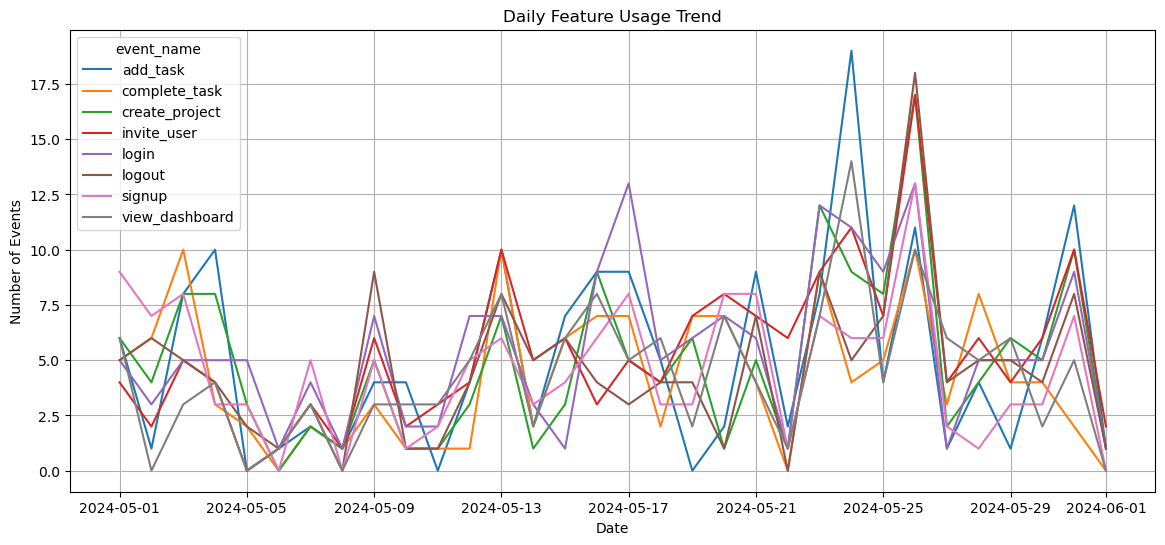

In [8]:
import matplotlib.pyplot as plt

event_trend = df.groupby(['date', 'event_name']).size().unstack().fillna(0)
event_trend.plot(figsize=(14,6))
plt.title("Daily Feature Usage Trend")
plt.ylabel("Number of Events")
plt.xlabel("Date")
plt.grid(True)
plt.show()


In [9]:
from collections import Counter

# First event of each user
first_events = df.groupby('user_id')['event_name'].first().value_counts()
print("First Action Distribution:\n", first_events)

# Funnel percentages
funnel_events = ['signup', 'login', 'view_dashboard', 'add_task']
for event in funnel_events:
    users = df[df['event_name'] == event]['user_id'].nunique()
    print(f"{event}: {users} users")


First Action Distribution:
 event_name
login             19
invite_user       17
logout            15
signup            13
create_project    11
complete_task      9
add_task           8
view_dashboard     8
Name: count, dtype: int64
signup: 74 users
login: 80 users
view_dashboard: 79 users
add_task: 71 users


In [10]:
df['signup_date'] = df[df['event_name'] == 'signup'].groupby('user_id')['timestamp'].transform('min')
df['cohort_week'] = df['signup_date'].dt.to_period('W').astype(str)
df['activity_week'] = df['timestamp'].dt.to_period('W').astype(str)

cohort = df.groupby(['cohort_week', 'activity_week'])['user_id'].nunique().unstack().fillna(0)

# Retention rate
cohort_retention = cohort.divide(cohort.iloc[:, 0], axis=0)
cohort_retention.style.format("{:.0%}")


activity_week,2024-04-29/2024-05-05,2024-05-06/2024-05-12,2024-05-13/2024-05-19,2024-05-20/2024-05-26,2024-05-27/2024-06-02
cohort_week,,,,,
2024-04-29/2024-05-05,100%,0%,0%,0%,0%
2024-05-06/2024-05-12,nan%,inf%,inf%,nan%,nan%
2024-05-13/2024-05-19,nan%,nan%,inf%,nan%,nan%
2024-05-20/2024-05-26,nan%,nan%,nan%,inf%,nan%
2024-05-27/2024-06-02,nan%,nan%,nan%,nan%,inf%
NaT,100%,113%,173%,213%,107%


<Axes: title={'center': 'Device Share'}, ylabel='count'>

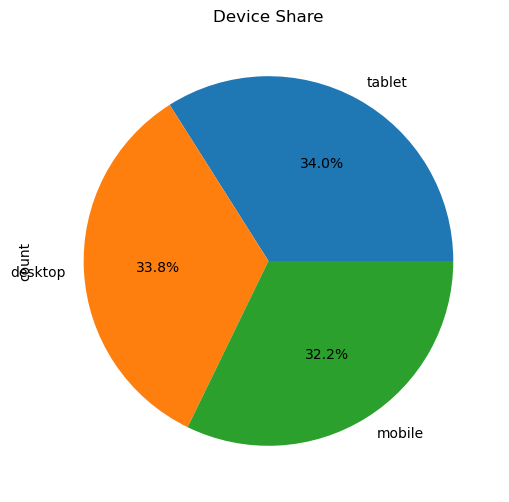

In [11]:
df['device'].value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(6,6), title="Device Share")


In [13]:
import pandas as pd
from datetime import timedelta

# Reload and clean timestamp
df = pd.read_csv("saas_product_usage_data.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Get last usage per user
last_event = df.groupby('user_id')['timestamp'].max().reset_index()
cutoff_date = df['timestamp'].max() - timedelta(days=7)

# Label users as churned or not
last_event['churn'] = (last_event['timestamp'] < cutoff_date).astype(int)


In [14]:
# Total events per user
user_activity = df.groupby('user_id').agg({
    'event_name': 'count',
    'timestamp': ['min', 'max'],
    'device': pd.Series.nunique,
    'page': pd.Series.nunique
})

# Rename columns
user_activity.columns = ['total_events', 'first_seen', 'last_seen', 'unique_devices', 'unique_pages']
user_activity.reset_index(inplace=True)

# Session duration
user_activity['usage_days'] = (user_activity['last_seen'] - user_activity['first_seen']).dt.days + 1


In [15]:
user_df = user_activity.merge(last_event[['user_id', 'churn']], on='user_id')
user_df.head()


,user_id,total_events,first_seen,last_seen,unique_devices,unique_pages,usage_days,churn
0,U1000,16,2024-05-03 18:00:00,2024-05-04 08:44:00,3,6,1,1
1,U1001,20,2024-05-23 20:00:00,2024-05-24 16:41:00,3,7,1,1
2,U1002,19,2024-05-01 16:00:00,2024-05-02 10:18:00,3,6,1,1
3,U1003,13,2024-05-17 04:00:00,2024-05-17 16:30:00,3,6,1,1
4,U1004,14,2024-05-27 15:00:00,2024-05-28 00:45:00,3,6,1,0


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Features and labels
X = user_df[['total_events', 'unique_devices', 'unique_pages', 'usage_days']]
y = user_df['churn']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model
model = LogisticRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.55      1.00      0.71        11

    accuracy                           0.55        20
   macro avg       0.28      0.50      0.35        20
weighted avg       0.30      0.55      0.39        20



C:\Users\Owner\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Owner\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Owner\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


<Axes: title={'center': 'Feature Importance'}>

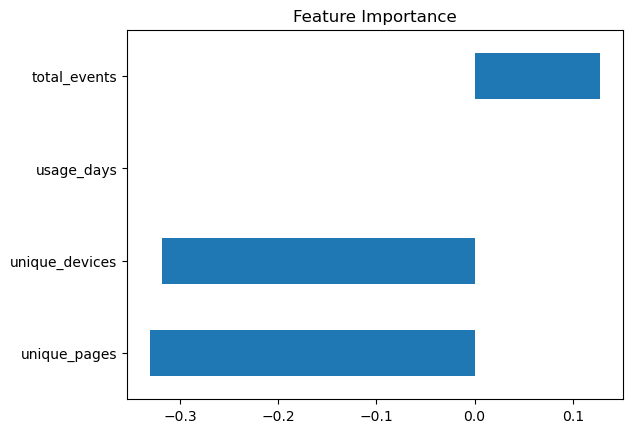

In [17]:
importance = pd.Series(model.coef_[0], index=X.columns)
importance.sort_values().plot(kind='barh', title='Feature Importance')


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)

# Evaluate
print("📊 Random Forest Report:")
print(classification_report(y_test, y_pred_rf))
print(confusion_matrix(y_test, y_pred_rf))


📊 Random Forest Report:
              precision    recall  f1-score   support

           0       0.57      0.44      0.50         9
           1       0.62      0.73      0.67        11

    accuracy                           0.60        20
   macro avg       0.59      0.59      0.58        20
weighted avg       0.60      0.60      0.59        20

[[4 5]
 [3 8]]


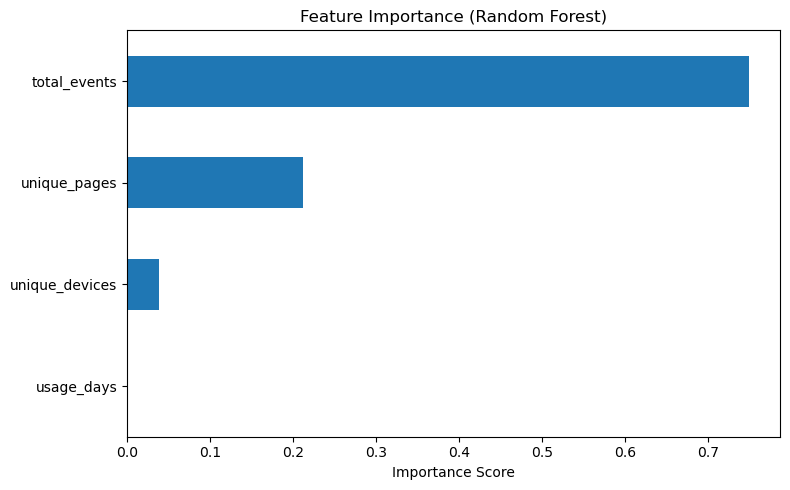

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Importance
feat_imp = pd.Series(rf.feature_importances_, index=X.columns)
feat_imp.sort_values().plot(kind='barh', title='Feature Importance (Random Forest)', figsize=(8, 5))
plt.xlabel("Importance Score")
plt.tight_layout()
plt.show()


In [23]:
# Ensure user_id columns are same type in both DataFrames
user_activity['user_id'] = user_activity['user_id'].astype(str)
last_event['user_id'] = last_event['user_id'].astype(str)

# Check columns present
print(user_activity.columns)
print(last_event.columns)

# Now merge
user_df = user_activity.merge(last_event[['user_id', 'churn']], on='user_id', how='inner')

# Preview the merged data
print(user_df.head())


Index(['user_id', 'total_events', 'first_seen', 'last_seen', 'unique_devices',
       'unique_pages', 'usage_days'],
      dtype='object')
Index(['user_id', 'timestamp', 'churn'], dtype='object')
  user_id  total_events          first_seen           last_seen  \
0   U1000            16 2024-05-03 18:00:00 2024-05-04 08:44:00   
1   U1001            20 2024-05-23 20:00:00 2024-05-24 16:41:00   
2   U1002            19 2024-05-01 16:00:00 2024-05-02 10:18:00   
3   U1003            13 2024-05-17 04:00:00 2024-05-17 16:30:00   
4   U1004            14 2024-05-27 15:00:00 2024-05-28 00:45:00   

   unique_devices  unique_pages  usage_days  churn  
0               3             6           1      1  
1               3             7           1      1  
2               3             6           1      1  
3               3             6           1      1  
4               3             6           1      0  


In [9]:
df.to_csv("C:\\Users\\Owner\\OneDrive\\Desktop\\DataAnalytics\\Saas Product Usage Analysis\\data\\saas_product_usage_data.csv", index=False)


